# Recollection routes coverage area

Define recollecetion routes coverage area and population living within their catchment area, as well as slope data.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


2023-11-15 16:43:21 Configured OSMnx 1.1.2
2023-11-15 16:43:21 HTTP response caching is on


## Download / load data

### Watershed

<AxesSubplot: >

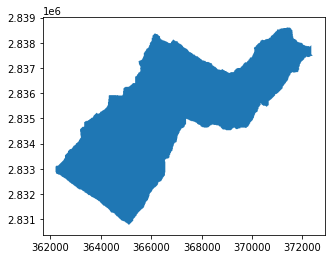

In [2]:
ws_gdf = gpd.read_file('../../data/processed/arroyovivo/cuenca_arroyo_32614.gpkg')
ws_gdf.plot()

### OSMnx

In [3]:
G,nodes,edges = aup.graph_from_hippo(ws_gdf, 'osmnx',edges_folder='edges_speed')
print('nodes:',nodes.shape,'edges:',edges.shape)

2023-11-15 16:43:34 Created graph from node/edge GeoDataFrames
nodes: (5313, 4) edges: (12418, 19)


<AxesSubplot: >

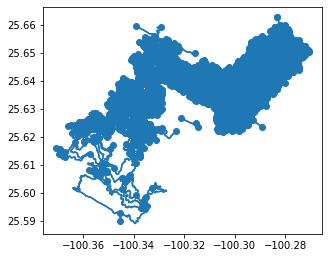

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
nodes.plot(ax=ax)
edges.plot(ax=ax)

### Population data

In [5]:
mnz_gdf = aup.gdf_from_polygon(ws_gdf,'censo','censo_mza_centroid_2020')
print(mnz_gdf.shape)
mnz_gdf.head(2)

(1093, 225)


,cvegeo,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,metropolis
0,1901900010399024,POINT (-100.33131 25.64923),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Monterrey
1,1901900010469004,POINT (-100.34868 25.63100),83,49,34,None,None,0,81,47,...,20,20,13,17,11,0,0,0,0,Monterrey


### Recollection routes centroid

In [6]:
r_gdf = gpd.read_file('../../data/processed/arroyovivo/rutas_recoleccionbasura.gpkg')
print(r_gdf.shape)
r_gdf.head(2)

(2822, 13)


,clave_zona,ejercicio,periodo,concesionario,numero_camion,nombre_asentamiento,turno,dias,hora_inicio,horario_fin,latitud,longitud,geometry
0,norte,2021,octubre-diciembre,red recolector sociedad anonima de capital var...,46,barrio aztlan,matutino,"lunes, miercoles, viernes",6:00:00,14:00:00,25.77698,-100.38417,POINT (361206.529 2851715.320)
1,norte,2021,octubre-diciembre,red recolector sociedad anonima de capital var...,8,urbivilla colonial,matutino,"lunes, miercoles, viernes",6:00:00,14:00:00,25.77373,-100.40607,POINT (359006.457 2851378.607)


## Spatial delimitation

In [7]:
r_gdf = r_gdf.clip(ws_gdf)
print(r_gdf.shape)

(195, 13)


In [8]:
r_gdf = r_gdf.drop_duplicates(subset='geometry')

## Proximity analysis

In [9]:
r_gdf = r_gdf.to_crs("EPSG:4326")
r_osmid = aup.find_nearest(G, nodes, r_gdf)
print(r_osmid.shape)
r_osmid.head(2)

(33, 14)


,clave_zona,ejercicio,periodo,concesionario,numero_camion,nombre_asentamiento,turno,dias,hora_inicio,horario_fin,latitud,longitud,geometry,osmid
1732,sur,2021,enero-marzo,red recolector sociedad anonima de capital var...,54,la republica,matutino,"martes, jueves, sabado",6:00:00,14:00:00,25.62557,-100.29928,POINT (-100.29928 25.62557),7832256166
589,sur,2021,julio-septiembre,red recolector sociedad anonima de capital var...,47,del paseo residencial,matutino,"martes, jueves, sabado",6:00:00,14:00:00,25.62603,-100.30053,POINT (-100.30053 25.62603),7047935721


In [10]:
edges.head(1)

,,,osmid,oneway,lanes,name,highway,length,geometry,grade,grade_abs,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
u,v,key,,,,,,,,,,,,,,,,,,,
4322078267,1693939445,0,191011469,False,None,Calle Paseo Belinda,residential,28.487,"LINESTRING (-100.31714 25.64226, -100.31699 25...",0.07,0.07,None,None,None,None,None,None,None,None,3.130818,0.545934


In [12]:
nodes_nearest = aup.calculate_distance_nearest_poi(r_osmid, nodes, edges, 'ruta',
                                  'osmid',wght='time_min',get_nearest_poi=(True,'osmid'))
print(nodes_nearest.shape)
nodes_nearest.head(2)

(5240, 6)


,x,y,street_count,geometry,nearest_poi,dist_ruta
osmid,,,,,,
293679561,-100.332355,25.650647,3,POINT (-100.33235 25.65065),1709299004,35.530365
293679705,-100.325947,25.646781,3,POINT (-100.32595 25.64678),1709299004,23.517306


<AxesSubplot: >

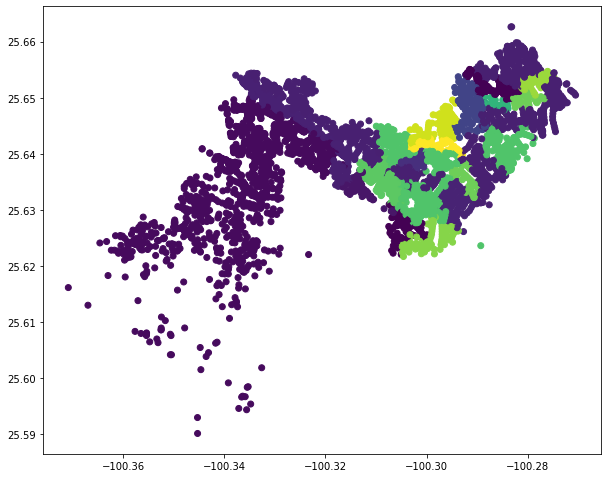

In [14]:
fig,ax = plt.subplots(figsize=(10,10))

nodes_nearest.plot('nearest_poi', ax=ax)

In [17]:
nodes_nearest.to_file('../../data/processed/arroyovivo/nodes_nearest.gpkg')

In [16]:
len(nodes_nearest.nearest_poi.unique())

33

In [18]:
nodes_nearest.nearest_poi.unique()

array([1709299004, 7047056467, 7230129129,  960056777, 1682150476,
       8752584837, 1682317137, 1681821852, 2643086336, 1681822347,
       7044891320, 1174051854, 1423289115, 1682152146, 1682152139,
       6460043227, 1682149141, 9359614049, 1761248820, 7047137978,
       7047935721, 1682148589, 8108552335,  944537609, 7487075220,
       1682317262, 7832256166, 1681821802, 7499398106, 7245107656,
       1682317412, 2065232839, 1682317998])